## Setup

In [1]:
import math

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading in Data

For this project, we are using a dataset from Kaggle containing 651,191 URLs and 4 classes (benign, defacement, phishing, and malware) [1]. Benign URLs are not malicious. Defacement URLs refer to trusted websites being hacked to include malicious content [2].

The URLs were gathered from multiple sources: an ISCX-URL2016 dataset from University of New Brunswick, a Phishtank dataset, a PhishStorm dataset, and a dataset of benign URLs from a git repository [1].

In [120]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


The class imbalance is shown below, with benign URLs consisting of the majority of the data points. Defacement and malware take second place, and phishing URLs consist of the smallest percentage of URLs.

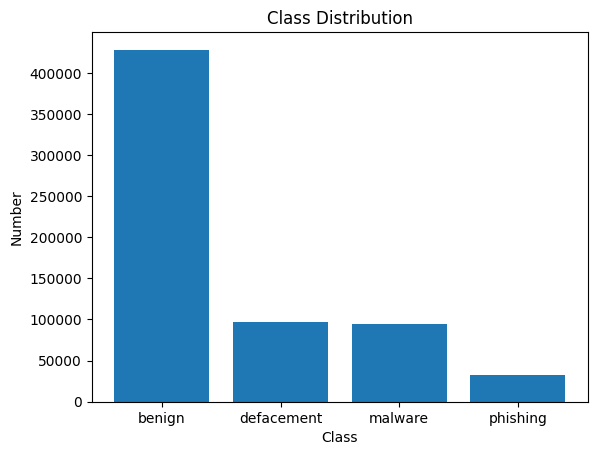

In [121]:
plt.bar(["benign", "defacement", "malware", "phishing"], [428103, 96547, 94111, 32520])
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution")
plt.show()

In [122]:
weights = 1.0 / original_df.groupby('type')['type'].transform('count')

In [123]:
weights.head()

0    0.000011
1    0.000002
2    0.000002
3    0.000010
4    0.000010
Name: type, dtype: float64

## Sampling the Data

I am taking a sample of the data to use in order to reduce computational complexity.

There are two methods shown below. The first method uses a percentage, while the other method uses an explicit number of samples.

I am also including the `weights` array I declared above to equally sample from all 4 classes.

In [124]:
# PERCENTAGE = 0.005
# df = original_df.sample(frac=PERCENTAGE, replace=False, random_state=42)

In [125]:
NUM_SAMPLES = 1000
df = original_df.sample(n=NUM_SAMPLES, replace=False, random_state=42, weights=weights)

In [126]:
df.shape

(1000, 2)

These cells below show the equalized class distribution. I created a dictionary object to store the counts for each class.

In [127]:
cnts = {"benign": 0, "defacement": 0, "phishing": 0, "malware": 0}
for ele in df["type"]:
    cnts[ele] += 1
print(cnts)

{'benign': 268, 'defacement': 251, 'phishing': 232, 'malware': 249}


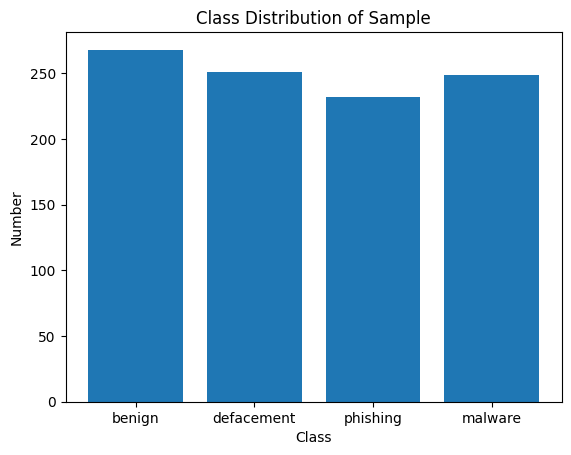

In [128]:
plt.bar(cnts.keys(), cnts.values())
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution of Sample")
plt.show()

## BERT Setup

I am loading the pre-trained model along with its tokenizer here.

BERT (Bi-Directional Pre-Trained Transformer) uses the encoder part of a transformer. This model is pre-trained under the MLM (masked language modeling) task on lots of data from the Internet. Therefore, the model has a good understanding of English grammar.

BERT is not trained in the classification task I want to perform, so I have to perform **fine-tuning** for BERT on a sample of the URL data.

This model does not need a large amount of data to fine-tune.

Each model has its own tokenizer because they each accept data in their own specific formats.

I am running this model on the SJSU HPC (High-Performance Cluster) servers, so I had to download the model from HuggingFace to use locally. 

In [129]:
MODEL = "./bert-base-uncased/"

In [130]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [131]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Dataset

Currently, the dataset is loaded into a Pandas dataframe. It has to be loaded into a HuggingFace Dataset format in order to be compatible with the HuggingFace model.

In [132]:
def convert_to_HF(df):
    dataset = Dataset.from_pandas(df)
    if "__index_level_0__" in list(dataset.features.keys()):
        dataset = dataset.remove_columns(["__index_level_0__"])
    dataset = dataset.class_encode_column("type")
    
    dataset = dataset.rename_column("url", "text")
    dataset = dataset.rename_column("type", "label")

    return dataset

BERT also expects the columns to be named "text" and "label".

In [133]:
dataset = convert_to_HF(df)

Casting to class labels: 100%|███| 1000/1000 [00:00<00:00, 141108.33 examples/s]


Here I am getting the label names.

In [134]:
target_labels = dataset.features["label"].names

In [135]:
target_labels

['benign', 'defacement', 'malware', 'phishing']

In [136]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

## BERT Tokenization

The URLs need to be converted into numbers, so I use the BERT tokenizer here to convert the inputs into a format that BERT can recognize.

BERT uses a WordPiece tokenizer [4]. It uses the following formula to figure out what tokens pairs to merge together [4]:
$$
\text{score} = \frac{\text{freq\_of\_pair}}{\text{freq\_of\_first\_element} \times \text{freq\_of\_second\_element}}
$$

It creates a library of tokens so that it can generalize to unseen words [4].

The formula above differentiates it from a more classic tokenization algorithm called BPE (byte-pair encoding), which only looks at the frequencies of token pairs [4].

In [137]:
def tokenize(data):
    return tokenizer(data["text"], padding="max_length", return_tensors="pt")

In [138]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 2729.71 examples/s]


In [139]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

## Dataset Split

I am splitting the dataset here into **train**, **validation**, and **test** sets.

In [140]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

In [141]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [142]:
train_eval_dataset = split_dataset["train"]

In [143]:
train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

Below are the three variables holding the data splits.

In [144]:
train_dataset = train_eval_split_dataset["train"]

In [145]:
eval_dataset = train_eval_split_dataset["test"]

In [146]:
test_dataset = split_dataset["test"]

Here you can see the number of data points for each data split.

In [147]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 810
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 90
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 100
 }))

## BERT Fine-Tuning

This object specifies the training configuration arguments.

The `output_dir` parameter specifies the directory where the model checkpoints will be stored. Model checkpoints store the model weights at predefined increments. 

The `num_train_epochs` parameter specifies the number of epochs that the model will train for. Each epoch goes through all of the batches of training data.

The `learning_rate` parameter controls how fast or how slow the model will learn. A higher learning rate will cause the model to converge faster, but a slower learning rate will slow down the model learning and lessen overfitting.

The `per_device_train_batch_size` parameter controls how large each batch of data is. 

In [148]:
training_args = TrainingArguments(output_dir="results", 
                                  num_train_epochs=5,
                                  logging_steps=1,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=8,
                                  weight_decay=0,
                                  evaluation_strategy="epoch")

I am using cross-entropy loss here because this is a multi-class classification problem

In [149]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sum = 0
    for i in range(len(labels)):
        raw_logits = logits[i]
        
        exp_logits = np.exp(raw_logits)
        norm_logits = exp_logits / np.sum(exp_logits, axis=0)
        chosen_value = norm_logits[labels[i]]
        
        sum += np.log(chosen_value)
    sum /= -len(labels)
    return {"cross_entropy": sum}

In [150]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [151]:
trainer.train()

Epoch,Training Loss,Validation Loss,Cross Entropy
1,0.062000,0.531213,0.531213
2,0.043900,0.506172,0.506172
3,0.027400,0.545509,0.545509
4,0.004600,0.499624,0.499624
5,0.003500,0.452084,0.452085


TrainOutput(global_step=510, training_loss=0.3429821028465442, metrics={'train_runtime': 253.2266, 'train_samples_per_second': 15.994, 'train_steps_per_second': 2.014, 'total_flos': 1065618909388800.0, 'train_loss': 0.3429821028465442, 'epoch': 5.0})

## Predictions

Now we perform prediction on the test dataset we put aside.

In [152]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [153]:
true_labels = test_dataset["label"]

In [154]:
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))

It is important to see how the model performs across the different classes. A single accuracy value averaged across all of the classes provides an insufficient evaluation of the model's performance. As mentioned earlier, there is a class imbalance. If the model boasts an accuracy of 90%, it does not provide information on the under-represented classes. Therefore, it is vital to look at the precision, recall, and F-1 score for each class. These metrics are detailed in the classification report below.

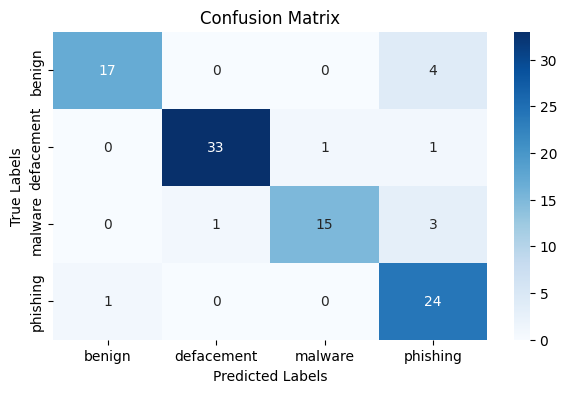

In [155]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [156]:
report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=target_labels, output_dict=False)
print(report)

              precision    recall  f1-score   support

      benign       0.94      0.81      0.87        21
  defacement       0.97      0.94      0.96        35
     malware       0.94      0.79      0.86        19
    phishing       0.75      0.96      0.84        25

    accuracy                           0.89       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.89      0.89       100



## More Testing

In [157]:
# test_data = Dataset.from_dict({ "text": ["https://uspz.usspapf.top"], "label": ["phishing"] })
# tokenized_test_data = test_data.map(tokenize, batched=True)
# tokenized_test_data

In [158]:
# trainer.predict(tokenized_test_data)

# Conclusion

BERT takes more computational power but can learn better with less samples. It removes the overhead of manually creating tokens or hand-engineered features. The main advantage to this method is the ability to generalize. However, it misses out on additional info, such as DNS/host information or webpage content.

A learning rate of 1e-5 has proven to be the sweet spot for this model to learn. A batch size of 4 or 16 either overfits or underfits.

For future work, I hope to try out different BERT models from HuggingFace  to try to improve performance.


# References

[1] https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

[2] https://www.unb.ca/cic/datasets/url-2016.html

[3] https://stackoverflow.com/questions/55042334/pandas-sample-with-weights 

[4] https://huggingface.co/learn/nlp-course/en/chapter6/6